2024-12-17 00:35:50.137867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734392150.255762    2295 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734392150.286060    2295 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 00:35:50.520671: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 22094 images belonging to 2 classes.
Found 5522 images belonging to 2 classes.


2024-12-17 00:35:59.235575: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.7268 - loss: 0.5961 - val_accuracy: 0.7381 - val_loss: 0.5053
Epoch 2/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 315s 911ms/step - accuracy: 0.7523 - loss: 0.5083 - val_accuracy: 0.7439 - val_loss: 0.4425
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 315s 910ms/step - accuracy: 0.7789 - loss: 0.4708 - val_accuracy: 0.8158 - val_loss: 0.3978
Epoch 4/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 316s 914ms/step - accuracy: 0.7901 - loss: 0.4518 - val_accuracy: 0.8305 - val_loss: 0.3756
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 315s 911ms/step - accuracy: 0.8012 - loss: 0.4441 - val_accuracy: 0.8415 - val_loss: 0.3529
Epoch 6/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 316s 912ms/step - accuracy: 0.8132 - loss: 0.4200 - val_accuracy: 0.8548 - val_loss: 0.3326
Epoch 7/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 316s 913ms/step - accuracy: 0.8169 - loss: 0.4151 - val_accuracy: 0.8566 - val_loss: 0.3178
Epoch 8/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 315s 911ms/step - accuracy: 0.8211 - lo

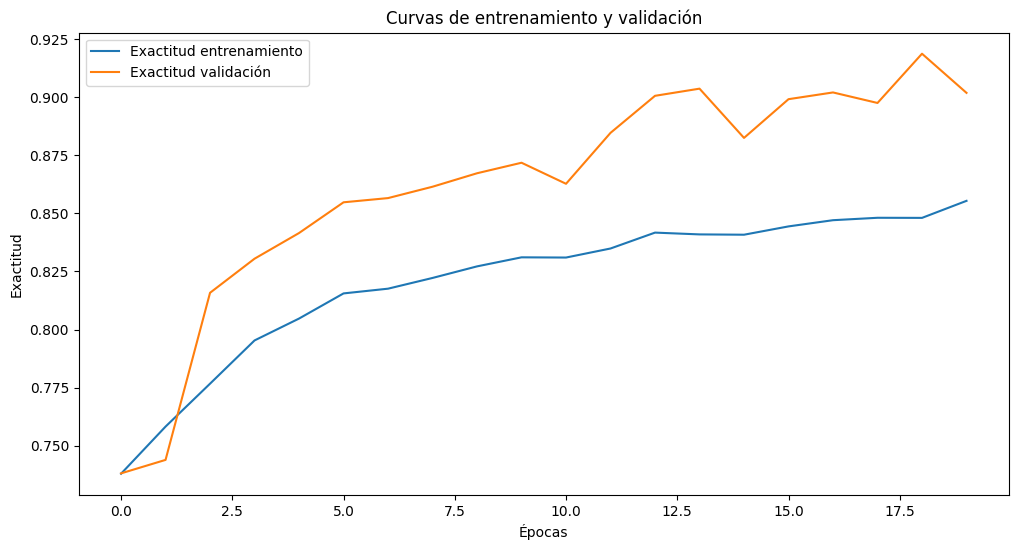

87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 476ms/step

Matriz de confusión:
 [[ 338 1108]
 [ 929 3147]]

Informe de clasificación:
               precision    recall  f1-score   support

       COVID       0.27      0.23      0.25      1446
      NORMAL       0.74      0.77      0.76      4076

    accuracy                           0.63      5522
   macro avg       0.50      0.50      0.50      5522
weighted avg       0.62      0.63      0.62      5522



In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.metrics import confusion_matrix, classification_report

# Configuración inicial
image_size = (128, 128)  # Tamaño de las imágenes para redimensionar
batch_size = 64

# Ruta al dataset (ajusta esto a tu entorno)
dataset_path = "./COVID-19_Radiography_Dataset2"

# Subcarpetas de las clases
categories = ["COVID", "NORMAL"]

# Configurar generador de datos con aumento
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,  # Dividir dataset
    rotation_range=10,     # Rotación aleatoria
    width_shift_range=0.1, # Desplazamiento horizontal
    height_shift_range=0.1, # Desplazamiento vertical
    zoom_range=0.1,        # Zoom aleatorio
    horizontal_flip=True,  # Inversión horizontal
)

# Crear generadores para entrenamiento y validación
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Crear el modelo
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')
])

# Compilación del modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Configurar Early Stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entrenamiento
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluar en el conjunto de validación
test_loss, test_acc = model.evaluate(val_generator, verbose=2)
print(f"Exactitud en validación: {test_acc:.2f}")

# Graficar curvas de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Exactitud entrenamiento')
plt.plot(history.history['val_accuracy'], label='Exactitud validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()
plt.title('Curvas de entrenamiento y validación')
plt.show()

# Predicciones
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
print("\nMatriz de confusión:\n", cm)

# Informe de clasificación
print("\nInforme de clasificación:\n", classification_report(y_true, y_pred_classes, target_names=categories))


In [ ]:
model.save("radiography_classification_model.h5")
print("Modelo guardado como 'radiography_classification_model.h5'.")

87/87 - 34s - 386ms/step - accuracy: 0.9129 - loss: 0.2084

Exactitud en validación: 0.91


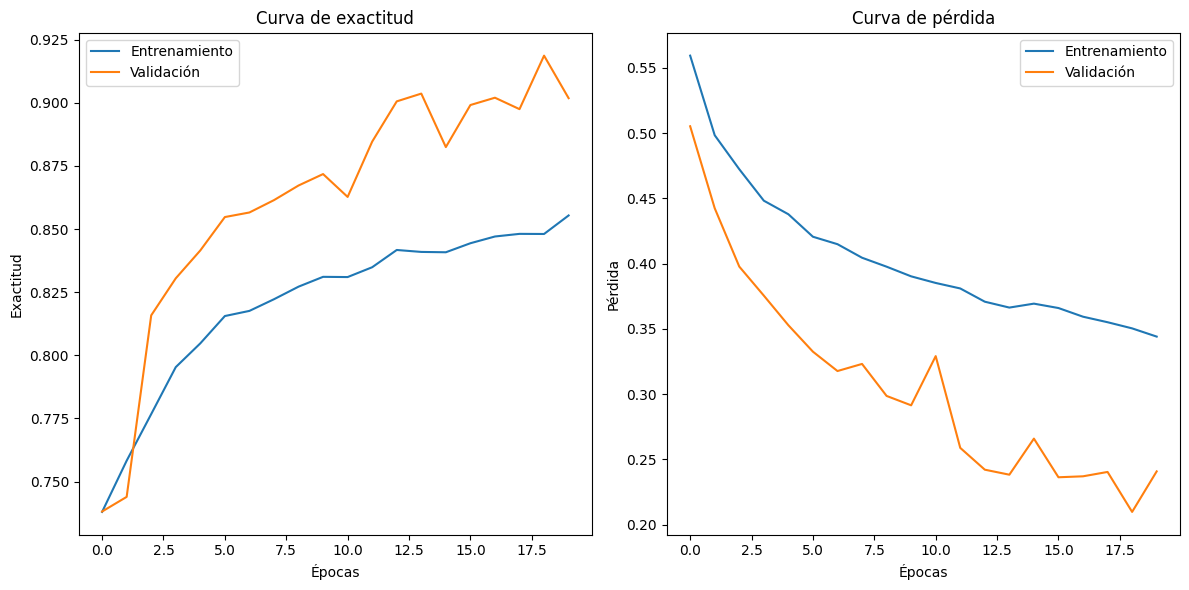

87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 461ms/step


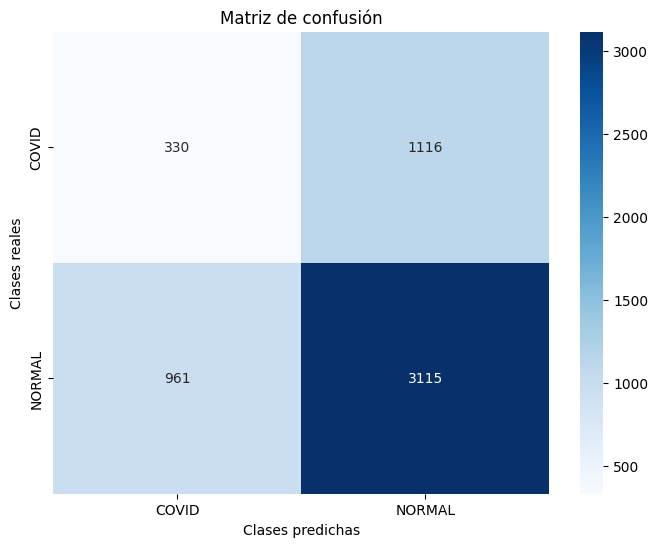


Informe de clasificación:

              precision    recall  f1-score   support

       COVID       0.26      0.23      0.24      1446
      NORMAL       0.74      0.76      0.75      4076

    accuracy                           0.62      5522
   macro avg       0.50      0.50      0.50      5522
weighted avg       0.61      0.62      0.62      5522



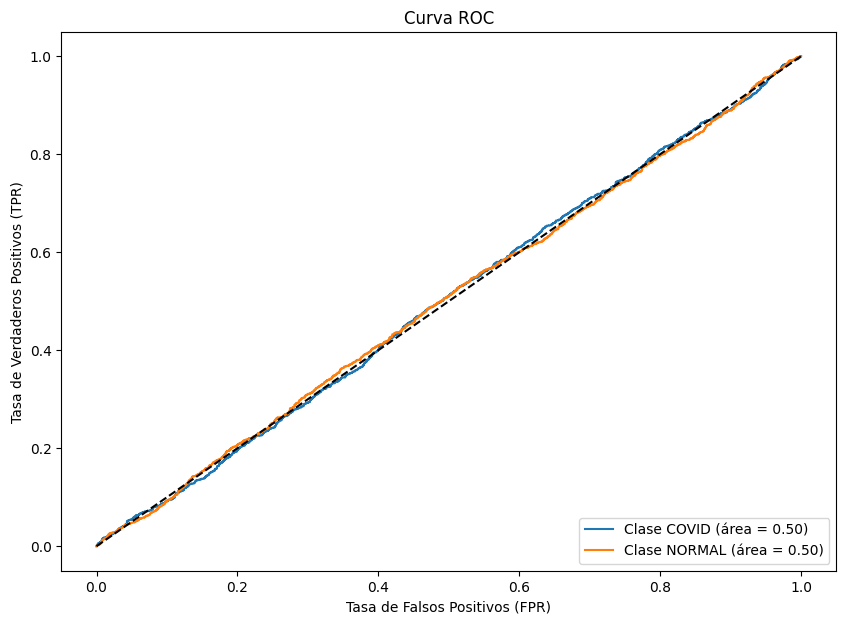

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Evaluar el modelo
test_loss, test_acc = model.evaluate(val_generator, verbose=2)
print(f"\nExactitud en validación: {test_acc:.2f}")

# Graficar curvas de entrenamiento y validación
plt.figure(figsize=(12, 6))

# Graficar la precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.title('Curva de exactitud')
plt.legend()

# Graficar la pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de pérdida')
plt.legend()

plt.tight_layout()
plt.show()

# Predicciones
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Clases predichas
y_true = val_generator.classes  # Clases reales

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.title('Matriz de confusión')
plt.xlabel('Clases predichas')
plt.ylabel('Clases reales')
plt.show()

# Informe de clasificación
print("\nInforme de clasificación:\n")
print(classification_report(y_true, y_pred_classes, target_names=categories))

# Graficar curva ROC
plt.figure(figsize=(10, 7))

for i, category in enumerate(categories):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {category} (área = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()